In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
# Stateful RNN - https://ahstat.github.io/RNN-Keras-time-series/

In [4]:
# https://stackoverflow.com/questions/52252442/how-to-handle-shift-in-forecasted-value

In [5]:
# Things to do
# try with long window size to see if shift forecasting is mitigated.
# Engineer a new feature from time series with differecing or squaring difference, rolling window, etc.

In [6]:
# Setting hyperparameters
batch_size = 64
epochs = 150
learning_rate = 0.001
hidden_shape = 64
num_layer = 1
l1 = False
l2 = False
lr_decay = False
model_type = "RNN"
# model_type = "GRU"
# model_type = "LSTM"

In [7]:
df = pd.read_csv("data/ac_data.csv")

df.head()

,date_time,temperature_datetime,temperature,airQuality_datetime,airQuality
0,2023-06-11 01:07:06.889863,2023-6-10-17-7-7,25.3750,2023-6-10-17-7-9,449
1,2023-06-11 01:12:07.465380,2023-6-10-17-12-4,25.3125,2023-6-10-17-12-8,461
2,2023-06-11 01:17:08.019617,2023-6-10-17-17-5,25.3125,2023-6-10-17-17-7,454
3,2023-06-11 01:22:08.641555,2023-6-10-17-22-8,25.1875,2023-6-10-17-22-9,460
4,2023-06-11 01:27:09.215907,2023-6-10-17-27-5,25.0625,2023-6-10-17-27-7,482


In [8]:
# Generating dataset

class device_data(Dataset):
    def __init__(self, X, window, horizon=0):
        self.X = []
        self.y = []
        self.len = X.shape[0]-window-1
        for i in range(0, len(X)-window-1-horizon):
            self.X.append(X[i:window+i])
            self.y.append(X[window+i: window+i+horizon+1])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return torch.Tensor(self.X[index]), torch.Tensor([self.y[index]])

In [9]:
scaler = MinMaxScaler()
scaler.fit(df["temperature"].to_numpy().reshape(-1, 1))
data = scaler.transform(df["temperature"].to_numpy().reshape(-1, 1))

In [10]:
# data = df["temperature"].to_numpy()

In [11]:
# Sequence lenght is 12. 1 hr duration
window = 12
horizon = 0

In [12]:
train = device_data(data.squeeze()[:800], window)
val = device_data(data.squeeze()[800:900], window)
test = device_data(data.squeeze()[900:], window)

In [13]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [14]:
dataset_iter = iter(train_loader)
temp = next(dataset_iter)
features, labels = temp
print(features.shape, labels.shape)

torch.Size([64, 12]) torch.Size([64, 1, 1])


C:\Users\siddp\AppData\Local\Temp\ipykernel_10396\3684639178.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.Tensor(self.X[index]), torch.Tensor([self.y[index]])


In [15]:
class RNNForecasting(nn.Module):
    def __init__(self, model_type, seq_length, input_shape, hidden_shape, output_shape, num_layers):
        super(RNNForecasting, self).__init__()
        self.hidden = hidden_shape
        self.num_layers = num_layers
        self.model = model_type
        if model_type == "RNN":
            self.rnn = nn.RNN(input_shape, hidden_shape, num_layers=num_layers, batch_first=True)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_shape, hidden_shape, num_layers=num_layers, batch_first=True)
        else:
            self.rnn = nn.LSTM(input_shape, hidden_shape, num_layers=num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_shape * seq_length, output_shape)

    def forward(self, x):
        batch_size = x.size(0)
        if self.model == "RNN" or self.model == "GRU":
            # h = torch.zeros([self.num_layers, batch_size, self.hidden])
            h = torch.zeros([self.num_layers, batch_size, self.hidden]).cuda()
            out, h = self.rnn(x, h)
        else:
            h = torch.zeros([self.num_layers, batch_size, self.hidden]).cuda()
            c = torch.zeros([self.num_layers, batch_size, self.hidden]).cuda()
            out, _ = self.rnn(x, (h, c))
        
        out = self.linear(out.contiguous().view(out.shape[0], -1))

        return out

    def compute_l1(self, w):
        return torch.abs(w).sum()

    def compute_l2(self, w):
      return torch.square(w).sum()

In [16]:
# Test model,
input_shape = 1
output_shape = 1
test = RNNForecasting(model_type, window, input_shape, hidden_shape, output_shape, num_layer).cuda()
# (seq,btch,in_sh)
out = test(features.unsqueeze(2).cuda())
print(out.shape)

torch.Size([64, 1])


### RNN

In [17]:
input_shape = 1
output_shape = 1
model = RNNForecasting(model_type, window, input_shape, hidden_shape, output_shape, num_layers=num_layer).cuda()

In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.9)

Epoch:  0 train:  0.3865114488532161 val:  0.15846444140506075
Epoch:  1 train:  0.22504196754786837 val:  0.09851182798120217
Epoch:  2 train:  0.16543416325995872 val:  0.1005926667397393
Epoch:  3 train:  0.11393277207699894 val:  0.09175377904905054
Epoch:  4 train:  0.09092082643578568 val:  0.08537072094836419
Epoch:  5 train:  0.08833711156461536 val:  0.0864441306738189
Epoch:  6 train:  0.10461882074155604 val:  0.08597110422122771
Epoch:  7 train:  0.08673196160066249 val:  0.08757087158123045
Epoch:  8 train:  0.08282548314113669 val:  0.08138390964553444
Epoch:  9 train:  0.08725553987779706 val:  0.08107203852692808
Epoch:  10 train:  0.09454562043826388 val:  0.08087934189983996
Epoch:  11 train:  0.08117534882120382 val:  0.08036131283387699
Epoch:  12 train:  0.07818981076200471 val:  0.0774068867236175
Epoch:  13 train:  0.08429035855408351 val:  0.07657617853484636
Epoch:  14 train:  0.08563807411970736 val:  0.07578094297930664
Epoch:  15 train:  0.07754352296165064 

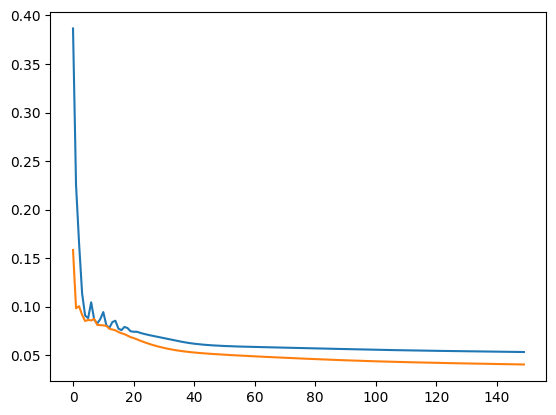

In [19]:
# Training
l1_weight = 0.01
l2_weight = 0.01
loss_train = []
loss_val = []
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.reshape(-1, 1).cuda()
        batch_x = batch_x.unsqueeze(2)
        optimizer.zero_grad()
        y_pred = model(batch_x)
        l = criterion(y_pred, batch_y)

        # Using l1 regularization
        # if l1:
        #     l1_parameters = []
        #     for parameter in model.parameters():
        #         l1_parameters.append(parameter.view(-1))
        #     L1 = l1_weight * model.compute_l1(torch.cat(l1_parameters))
        #     l += L1

        # # Using l2 regularization
        # if l2:
        #     l2_parameters = []
        #     for parameter in model.parameters():
        #         l2_parameters.append(parameter.view(-1))
        #     L1 = l2_weight * model.compute_l2(torch.cat(l2_parameters))
        #     l += L1

        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        optimizer.step()
    # if lr_decay:
    #     epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.reshape(-1, 1).cuda()
            batch_x = batch_x.unsqueeze(2)
            output = model(batch_x)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            # preds.append(output.detach().numpy())
            # true.append(batch_y.detach().numpy())
            mse_val += criterion(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    print("Epoch: ", i, "train: ", (mse_train/train.__len__())**0.5, "val: ", (mse_val/val.__len__())**0.5)
    loss_train.append((mse_train/train.__len__())**0.5)
    loss_val.append((mse_val/val.__len__())**0.5)


plt.plot(loss_train)
plt.plot(loss_val)
plt.show()    

In [20]:
# Testing the model

with torch.no_grad():
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.reshape(-1, 1).cuda()
        batch_x = batch_x.unsqueeze(2)
        output = model(batch_x)
        # output = output.squeeze(1)
        preds.append(scaler.inverse_transform(output.detach().cpu().numpy()))
        true.append(scaler.inverse_transform(batch_y.detach().cpu().numpy()))

        # preds.append(output.detach().cpu().numpy())
        # true.append(batch_y.detach().cpu().numpy())

    preds = np.concatenate(preds)
    true = np.concatenate(true)

    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)

    print(mse, mae)

0.32299578 0.43288994


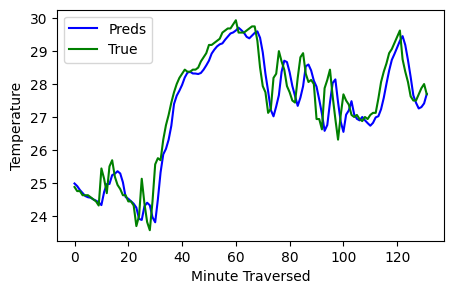

In [21]:
plt.figure(figsize=(5, 3))
# plt.plot(preds[2:], 'b', label='Preds')
# plt.plot(true[:-2], 'g', label='True')
plt.plot(preds, 'b', label='Preds')
plt.plot(true, 'g', label='True')
plt.legend()
plt.xlabel("Minute Traversed")
plt.ylabel("Temperature")
plt.show()

In [22]:
# Step 2: Release GPU memory (if applicable)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Step 3: Delete model and optimizer objects
del model
del optimizer

### GRU

In [23]:
# Setting hyperparameters
batch_size = 64
epochs = 150
learning_rate = 0.001
hidden_shape = 64
num_layer = 1
l1 = False
l2 = False
lr_decay = False
# model_type = "RNN"
model_type = "GRU"
# model_type = "LSTM"

In [24]:
input_shape = 1
output_shape = 1
model_gru = RNNForecasting(model_type, window, input_shape, hidden_shape, output_shape, num_layers=num_layer).cuda()

In [25]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_gru.parameters(), lr=learning_rate)

epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.9)

Epoch:  0 train:  0.447228427069809 val:  0.12977497640948701
Epoch:  1 train:  0.2553259293368904 val:  0.12271124728584792
Epoch:  2 train:  0.19708062734617018 val:  0.0987280562368768
Epoch:  3 train:  0.14081795012113468 val:  0.10316801725219708
Epoch:  4 train:  0.09872605446909131 val:  0.08950891970516126
Epoch:  5 train:  0.08868046986943744 val:  0.0923260748457532
Epoch:  6 train:  0.08698799037233246 val:  0.08872288181382623
Epoch:  7 train:  0.08717063935462356 val:  0.08840710342817436
Epoch:  8 train:  0.08572413262070051 val:  0.0876956262454228
Epoch:  9 train:  0.0848907931113634 val:  0.08669447474659846
Epoch:  10 train:  0.08453368064105425 val:  0.08599852943029844
Epoch:  11 train:  0.08391359415539633 val:  0.08511080874539538
Epoch:  12 train:  0.08348503034678 val:  0.08429268434565965
Epoch:  13 train:  0.08293176057231444 val:  0.08347960766603643
Epoch:  14 train:  0.08229629555771387 val:  0.08259430622336231
Epoch:  15 train:  0.08173754434046548 val:  

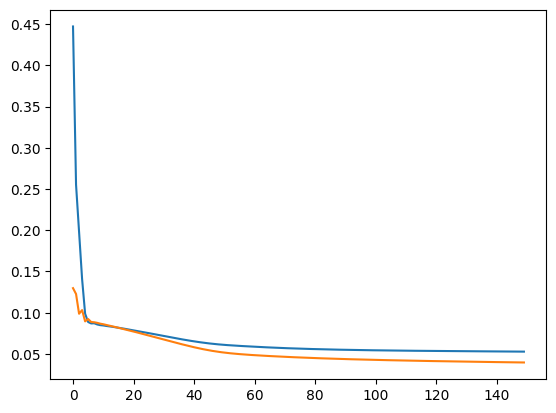

In [26]:
# Training
l1_weight = 0.01
l2_weight = 0.01
loss_train = []
loss_val = []
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.reshape(-1, 1).cuda()
        batch_x = batch_x.unsqueeze(2)
        optimizer.zero_grad()
        y_pred = model_gru(batch_x)
        l = criterion(y_pred, batch_y)

        # Using l1 regularization
        # if l1:
        #     l1_parameters = []
        #     for parameter in model.parameters():
        #         l1_parameters.append(parameter.view(-1))
        #     L1 = l1_weight * model.compute_l1(torch.cat(l1_parameters))
        #     l += L1

        # # Using l2 regularization
        # if l2:
        #     l2_parameters = []
        #     for parameter in model.parameters():
        #         l2_parameters.append(parameter.view(-1))
        #     L1 = l2_weight * model.compute_l2(torch.cat(l2_parameters))
        #     l += L1

        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        optimizer.step()
    # if lr_decay:
    #     epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.reshape(-1, 1).cuda()
            batch_x = batch_x.unsqueeze(2)
            output = model_gru(batch_x)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            # preds.append(output.detach().numpy())
            # true.append(batch_y.detach().numpy())
            mse_val += criterion(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    print("Epoch: ", i, "train: ", (mse_train/train.__len__())**0.5, "val: ", (mse_val/val.__len__())**0.5)
    loss_train.append((mse_train/train.__len__())**0.5)
    loss_val.append((mse_val/val.__len__())**0.5)


plt.plot(loss_train)
plt.plot(loss_val)
plt.show()    

In [28]:
# Testing the model

with torch.no_grad():
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.reshape(-1, 1).cuda()
        batch_x = batch_x.unsqueeze(2)
        output = model_gru(batch_x)
        # output = output.squeeze(1)
        preds.append(scaler.inverse_transform(output.detach().cpu().numpy()))
        true.append(scaler.inverse_transform(batch_y.detach().cpu().numpy()))

        # preds.append(output.detach().cpu().numpy())
        # true.append(batch_y.detach().cpu().numpy())

    preds = np.concatenate(preds)
    true = np.concatenate(true)

    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)

    print(mse, mae)

0.30089846 0.4256313


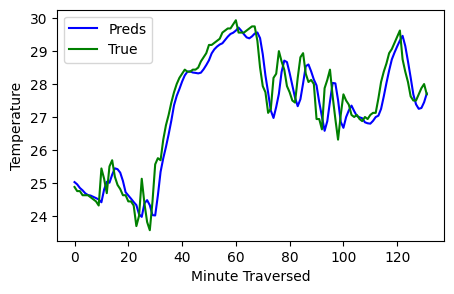

In [29]:
plt.figure(figsize=(5, 3))
# plt.plot(preds[2:], 'b', label='Preds')
# plt.plot(true[:-2], 'g', label='True')
plt.plot(preds, 'b', label='Preds')
plt.plot(true, 'g', label='True')
plt.legend()
plt.xlabel("Minute Traversed")
plt.ylabel("Temperature")
plt.show()

In [31]:
# Step 2: Release GPU memory (if applicable)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Step 3: Delete model and optimizer objects
del model_gru
del optimizer

### LSTM

In [32]:
# Setting hyperparameters
batch_size = 64
epochs = 150
learning_rate = 0.001
hidden_shape = 64
num_layer = 1
l1 = False
l2 = False
lr_decay = False
# model_type = "RNN"
# model_type = "GRU"
model_type = "LSTM"

In [33]:
input_shape = 1
output_shape = 1
model_lstm = RNNForecasting(model_type, window, input_shape, hidden_shape, output_shape, num_layers=num_layer).cuda()

In [34]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.9)

Epoch:  0 train:  0.45784563318577665 val:  0.12849874737144937
Epoch:  1 train:  0.2576510266793727 val:  0.14892530741309817
Epoch:  2 train:  0.2252512032558324 val:  0.1104201382265226
Epoch:  3 train:  0.20016693832512525 val:  0.10680922151537392
Epoch:  4 train:  0.16517581948072277 val:  0.09951434138274105
Epoch:  5 train:  0.13690878069703794 val:  0.09355793568034902
Epoch:  6 train:  0.10443498368216869 val:  0.09174030787936649
Epoch:  7 train:  0.09180096800058983 val:  0.09225211792987918
Epoch:  8 train:  0.09312831710993325 val:  0.09256087805350072
Epoch:  9 train:  0.0911796106057501 val:  0.08960905595466555
Epoch:  10 train:  0.09088257919195175 val:  0.09014358702412041
Epoch:  11 train:  0.08860256189950473 val:  0.08940064427750509
Epoch:  12 train:  0.088501748196694 val:  0.08882325245067475
Epoch:  13 train:  0.08839604385261957 val:  0.08811651168298441
Epoch:  14 train:  0.08781780473533958 val:  0.0877966757460888
Epoch:  15 train:  0.08705131974494869 val

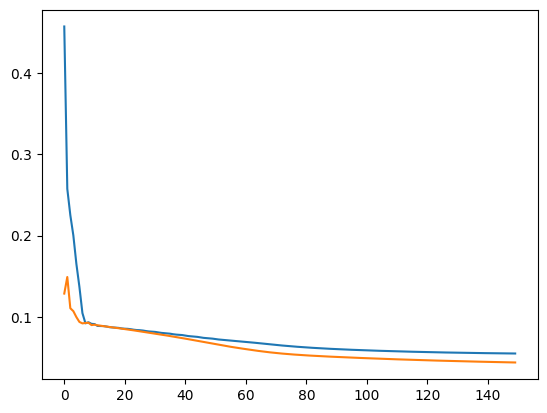

In [35]:
# Training
l1_weight = 0.01
l2_weight = 0.01
loss_train = []
loss_val = []
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.reshape(-1, 1).cuda()
        batch_x = batch_x.unsqueeze(2)
        optimizer.zero_grad()
        y_pred = model_lstm(batch_x)
        l = criterion(y_pred, batch_y)

        # Using l1 regularization
        # if l1:
        #     l1_parameters = []
        #     for parameter in model.parameters():
        #         l1_parameters.append(parameter.view(-1))
        #     L1 = l1_weight * model.compute_l1(torch.cat(l1_parameters))
        #     l += L1

        # # Using l2 regularization
        # if l2:
        #     l2_parameters = []
        #     for parameter in model.parameters():
        #         l2_parameters.append(parameter.view(-1))
        #     L1 = l2_weight * model.compute_l2(torch.cat(l2_parameters))
        #     l += L1

        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        optimizer.step()
    # if lr_decay:
    #     epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.reshape(-1, 1).cuda()
            batch_x = batch_x.unsqueeze(2)
            output = model_lstm(batch_x)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            # preds.append(output.detach().numpy())
            # true.append(batch_y.detach().numpy())
            mse_val += criterion(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    print("Epoch: ", i, "train: ", (mse_train/train.__len__())**0.5, "val: ", (mse_val/val.__len__())**0.5)
    loss_train.append((mse_train/train.__len__())**0.5)
    loss_val.append((mse_val/val.__len__())**0.5)


plt.plot(loss_train)
plt.plot(loss_val)
plt.show()    

In [36]:
# Testing the model

with torch.no_grad():
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.reshape(-1, 1).cuda()
        batch_x = batch_x.unsqueeze(2)
        output = model_lstm(batch_x)
        # output = output.squeeze(1)
        preds.append(scaler.inverse_transform(output.detach().cpu().numpy()))
        true.append(scaler.inverse_transform(batch_y.detach().cpu().numpy()))

        # preds.append(output.detach().cpu().numpy())
        # true.append(batch_y.detach().cpu().numpy())

    preds = np.concatenate(preds)
    true = np.concatenate(true)

    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)

    print(mse, mae)

0.36601606 0.48059505


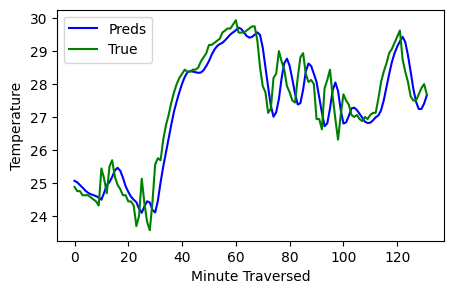

In [37]:
plt.figure(figsize=(5, 3))
# plt.plot(preds[2:], 'b', label='Preds')
# plt.plot(true[:-2], 'g', label='True')
plt.plot(preds, 'b', label='Preds')
plt.plot(true, 'g', label='True')
plt.legend()
plt.xlabel("Minute Traversed")
plt.ylabel("Temperature")
plt.show()

In [38]:
# Step 2: Release GPU memory (if applicable)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Step 3: Delete model and optimizer objects
del model_lstm
del optimizer

### Saving config

In [39]:
# Creating/updating config file with hyperparameters and model performance
import os
from pathlib import Path
import json

filepath = "config/config.json"
filepath = Path(filepath)
filedir, filename = os.path.split(filepath)

dic = {
    "model": model_type,
    "batch_size": batch_size,
    "epochs": epochs,
    "learning_rate": learning_rate,
    "hidden_shape": hidden_shape,
    "num_layer": num_layer,
    "l1": l1,
    "l2": l2,
    "lr_decay": lr_decay,
    "MAE": str(mae),
    "MSE": str(mse),
    "window_size": str(window),
    "horizon": str(horizon)
}

# Serializing json
json_object = json.dumps(dic, indent=4)

try:
    with open(filepath, "r") as file:
        existing_data = json.load(file)
        existing_data.append(json_object)
        with open(filepath, "w") as file:
            json.dump(existing_data, file, indent=None)
        print("New configuration for the model added")
except FileNotFoundError:
    if filedir != "":
        os.makedirs(filedir, exist_ok=True)
        print(f"Creating directory:{filedir} for the file {filename}")

    existing_data = []
    existing_data.append(json_object)
    with open(filepath, "w") as file:
        json.dump(existing_data, file, indent=None)

    print("New config file is created with first configuration for the model")
        

New configuration for the model added
